In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm
import time
import KalmanFilter

In [2]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [52]:
thymio_data = []
Ts = 0.1

def motors(l_speed=500, r_speed=500):
    return {
        "motor.left.target": [l_speed],
        "motor.right.target": [r_speed],
    }

async def forward(motor_speed):
    await node.set_variables(motors(motor_speed,motor_speed))

async def rotate(theta, motor_speed): #theta is in radians
    direction_rot=(theta>=0)-(theta<0)
    await node.set_variables(motors(motor_speed*direction_rot, -motor_speed*direction_rot))
    # wait time to get theta 1.44 is the factor to correct
    time=(theta)*100/motor_speed*1.44
    await(client.sleep(time))
    # stop the robot
    await node.set_variables(motors(0, 0))

async def stop_motor():
    await node.set_variables(motors(0,0))

async def get_proximity_values():
    # Wait for the Thymio node
    node = await client.wait_for_node()
    # Wait for the proximity sensor variables
    await node.wait_for_variables({"prox.horizontal"})
    # Get the proximity values : v: Stands for "variables" and is used to access the cached variable values.
    proximity_values = node.v.prox.horizontal
    # Return the value of the front proximity sensor (index 2)
    return proximity_values[0:5]

## Parameters for local navigation
threshold_obst = 3500 
threshold_loc = 2500
local_motor_speed = 100
threshold_obst_list = [3200, 3600, 3600, 3600, 3200]

async def local_navigation():
    threshold_obst = 1000
    threshold_loc = 800
    local_motor_speed = 100
    threshold_obst_list = [3200, 3600, 3600, 3600, 3200]
    sens = await get_proximity_values()

    # Follow the obstacle by the left
    if (sens[0] + sens[1]) > (sens[4] + sens[3]):
        await bypass('right', sens, threshold_loc, local_motor_speed)

    # Follow the obstacle by the right    
    else:
        await bypass('left', sens, threshold_loc, local_motor_speed)

async def bypass(leftright, sens, threshold_loc, local_motor_speed):
    if leftright == "right":
        while sum(sens[i] > threshold_obst for i in range(0, 5)) > 0:
            print("Turn right")
            await rotate(np.pi/6/2, local_motor_speed)
            sens = await get_proximity_values()
            print(sens)

        while sens[0] > threshold_loc:
            await forward(local_motor_speed)
            sens = await get_proximity_values()
        
    elif leftright == "left":
        while sum(sens[i] > threshold_loc for i in range(0, 5)) > 0:
            print("Turn left")
            await rotate(-np.pi/6, local_motor_speed)
            sens = await get_proximity_values()

        while sens[4] > threshold_loc:
            await forward(local_motor_speed)
            sens = await get_proximity_values()

    if (leftright=="right" and sens[0] < threshold_loc):
        await forward(local_motor_speed)
        time.sleep(2)
        await rotate(-np.pi/4, 100)    

    await forward(local_motor_speed)
    await stop_motor()

def get_data():
    thymio_data.append({"sensor":node["prox.horizontal"],
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})

async def get_speed():
    await node.wait_for_variables() # wait for Thymio variables values
    rt = RepeatedTimer(Ts, get_data) # it auto-starts, no need of rt.start()

    try:
        await client.sleep(Ts)
    finally:
        rt.stop()
        node.send_set_variables(motors(0, 0))

def speed_estimation(left_speed, right_speed):
    real_thymio_speed = 25.5 #mm/s
    real_thymio_angular_speed = 0.38 #rad/s
    command_motor_for_calibration = 50

    #speed estimation
    speed_measured = (right_speed + left_speed)/2
    speed = (speed_measured * real_thymio_speed) / command_motor_for_calibration
    angular_speed_measured = (right_speed - left_speed)/2
    angular_speed = (angular_speed_measured * real_thymio_angular_speed) / command_motor_for_calibration

    return speed, angular_speed

def real_speed(command_motor):
    real_thymio_speed = 25.5 #mm/s
    real_thymio_angular_speed = 0.38 #rad/s

    speed_motor = (command_motor[0] * real_thymio_speed) / 50
    angular_speed_motor = (command_motor[1] * real_thymio_angular_speed) / 50

    return speed_motor, angular_speed_motor

def pos_estimation(speed, angular_speed, dt, previous_state_estimation):
    A = np.identity(3)
    B = np.array([[np.cos(previous_state_estimation[2]).item() * dt, 0, 0],
                  [np.sin(previous_state_estimation[2]).item() * dt, 0, 0],
                  [0, dt, 0]])
    input_vector = np.array([[speed], [angular_speed], [0]])
    state_estimation = np.dot(A, previous_state_estimation) + np.dot(B, input_vector)

    return state_estimation

In [53]:
def kalman_filter(command_motor, speed, angular_speed, position_camera_history, previous_state_estimation, previous_covariance_estimate, dt,
                  HT=None, HNT=None, RT=None, RNT=None):
    """
    Estimates the current state using input sensor data and the previous state
    
    param command_motor: command sent to the motors
    param speed: measured speed (Thymio units)
    param angular_speed: measured angular speed (Thymio units)
    param position_camera_history: last position coordinates given by the camera
    param previous_state_estimation
    param previous_covariance_estimate: previous state a posteriori covariance
    param dt: time step
    
    return state_estimate: new a posteriori state estimation
    return P_estimate: new a posteriori state covariance (incertitude)
    """

    # Initialising the constants
    std_speed = 8.77 #mm^2/s^2
    std_angular_speed = 0.05 #rad^2/s^2
    #Assuming that half og the varance is caused by the measurements and half is caused by perturbations to the states
    q_nu = std_speed / 2 # variance on angular state
    r_nu_translation = std_speed / 2 # variance on speed measurement
    r_nu_rotation = std_angular_speed / 2 # variance on angular speed measurement

    qp = 0.04 # variance on position state in mm chosen arbitrarily: √qp = 0.2
    rp = 1 # variance on position measurement in mm
    rp_angle = 0.02 # variance on angle measurement in rad
    Q = np.array([[qp, 0, 0], [0, qp, 0], [0, 0, q_nu]]) # process noise covariance matrix

    if len(position_camera_history) > 1:
        last_position_camera, position_camera = position_camera_history[-2], position_camera_history[-1]
    else:
        last_position_camera, position_camera = None, None

    ## Prediciton through the a priori estimate
    #predicted_state_estimate = np.dot(A, previous_state_estimation) + np.dot(B, input_vector)
    speed_motor, angular_speed_motor = real_speed(command_motor)
    predicted_state_estimate = pos_estimation(speed_motor, angular_speed_motor, dt, previous_state_estimation)
    predicted_state_estimate_derivative = np.array([[1 - angular_speed_motor * np.sin(previous_state_estimation[2].item()) * dt, 0, 0],
                                                    [angular_speed_motor * np.cos(previous_state_estimation[2]).item() * dt, 1, 0],
                                                    [0, 0, 1]])
    predicted_covariance_estimate = np.dot(predicted_state_estimate_derivative, np.dot(previous_covariance_estimate, predicted_state_estimate_derivative.T)) + Q
    
    ## Update         
    if last_position_camera != position_camera and position_camera is not None:
        # camera position is available
        y = np.array([position_camera])
        H = np.identity(3)
        R = np.array([[rp, 0, 0], [0, rp, 0, 0], [0, 0, rp_angle]])
    else:
        # no camera position, use only the speed measurement
        y = np.array(pos_estimation(speed, angular_speed, dt, previous_state_estimation))
        H = np.identity(3)
        R = np.array([[r_nu_translation, 0, 0], [0, r_nu_translation, 0], [0, 0, r_nu_rotation]])

    # innovation / measurement residual
    i = y - np.dot(H, previous_state_estimation)
    # measurement prediction covariance
    S = np.dot(H, np.dot(previous_covariance_estimate, H.T)) + R
             
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(previous_covariance_estimate, np.dot(H.T, np.linalg.inv(S)))
    
    # Updated state and covariance estimate
    state_estimate = predicted_state_estimate + np.dot(K, i)
    #P_estimate = previous_covariance_estimate - np.dot(K, np.dot(H, previous_covariance_estimate))
    P_estimate = np.dot((np.identity(3) - np.dot(K, H)), predicted_covariance_estimate)
     
    return state_estimate, P_estimate

In [54]:
async def get_position(start_time, state_estimate, P_estimate, command_motor):

    await get_speed()
    left_speed = node["motor.left.speed"]
    right_speed = node["motor.right.speed"]
    dt = time.time() - start_time 
    speed, angular_speed = speed_estimation(left_speed, right_speed)

    camera_position_histoty = []
    camera_position = [np.array([[0], [0], [0]])] #get_camera_position()
    camera_position_histoty.append(camera_position)
    camera_position = [np.array([[0], [0], [0]])] #get_camera_position()
    
    new_state_estimate, new_P_estimate = kalman_filter(command_motor, speed, angular_speed, camera_position_histoty, state_estimate[-1], P_estimate[-1], dt)
    state_estimate.append(new_state_estimate)
    P_estimate.append(new_P_estimate)

    return state_estimate, P_estimate, speed, angular_speed

In [55]:
#MAIN CODE : 

#parameters
local_obstacle = False
threshold_obst = 3500 #threshold for obstacle detection
pos_x, pos_y, theta = 0, 0, 0
command_motor = [100, 100]
speed_history = []
angular_speed_history = []
camera_position_histoty = []
thymio_data.clear()

async def main():

    global local_obstacle, pos_x, pos_y, theta
    start_time = time.time()
    state_estimate = [np.array([[0], [0], [0]])]
    P_estimate = [1000 * np.ones(3)]

    while(1):
        sens = await get_proximity_values()
        if (sum(sens[i] > threshold_obst for i in range(0, 5)) > 0):
            local_obstacle = True

        if(local_obstacle):
            #await local_navigation()
            break
            start_time = time.time() #reset the timer          

        if not local_obstacle: 
            node.send_set_variables(motors(command_motor[0], command_motor[1]))
            state_estimate, P_estimate, speed, angular_speed = await get_position(start_time, state_estimate, P_estimate, command_motor)
            speed_history.append(speed)
            angular_speed_history.append(angular_speed)
            start_time = time.time()
            print(state_estimate[-1][0]/10, state_estimate[-1][1]/10, (state_estimate[-1][2]*180)/np.pi)

await main()
std_speed = np.std(speed_history[10:])
std_angular_speed = np.std(angular_speed_history[10:])
print("The speed variance in mm^2/s^2 is {}".format(std_speed))
print("The angular speed variance in rad^2/s^2 is {}".format(std_angular_speed))

[28.10539191] [0.] [239.96930525]
[27.69552458] [-0.61755549] [243.5531427]
[27.38637065] [-1.17256153] [248.10675514]
[27.0951309] [-1.74968276] [252.46313561]
[26.45517545] [-2.92086104] [256.69029685]
[22.52683345] [-10.17491534] [262.40865857]
[30.73382428] [7.91041971] [267.22204092]
[18.74573255] [-26.31655125] [272.15275056]
[73.03444876] [168.54399266] [276.87607619]
[-734.03748343] [-3541.46830434] [281.90344571]
[-1429.0065873] [-7677.07158929] [286.41019766]
[-41661.19235058] [-321784.34846657] [291.81644702]
[-17863.19871248] [-68265.35160062] [296.54308946]
[209764.70346299] [3504637.72597583] [300.99931803]
[476680.83824595] [11002790.39382466] [305.74136057]
[1437631.0892432] [1.19357028e+08] [310.10562789]
[15745030.50049276] [-7.13686941e+08] [314.53141902]
[1.02066119e+08] [-2.71013857e+09] [319.13073769]
[1.5259955e+09] [-2.32757193e+10] [323.63638929]
[4.45402791e+09] [-5.381787e+10] [328.28180654]
[-2.04275993e+11] [1.64257725e+12] [333.26013512]
[-2.99202283e+10] 

In [13]:
await node.set_variables(motors(0, 0))

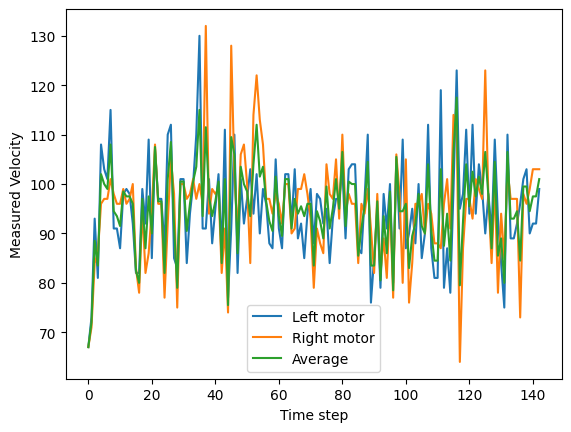

In [21]:
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed, label="Average")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()